Ellenőrzésképpen vannak benne print ek hogy le tudjam ellenőrizni hogy jól dolgoztam e

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
# Standard library imports.
import pickle
from collections import namedtuple

# Related third party imports.
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

# Local application/library specific imports.
import src.models.id_network as id_network
import src.models.inter_dependency as inter_dependency
import src.processing as processing
import src.models.scores as scores

Beolvassuk a hálózatot:

In [61]:
P = nx.read_gml("../data/processed/networks/italy/italy_power.gml")
C = nx.read_gml("../data/processed/networks/italy/italy_communication.gml")
id_12, id_21 = inter_dependency.id_closest_nodes(P,C)

processing.add_edge_length(P)
processing.add_edge_length(C)

model = id_network.Basic(P, C, id_12, id_21)

full_network_cost = sum(sum(cost_dict.values()) for cost_dict in model.upgrade_cost.values())

[            setup_dependencies()] New dependencies set!
[         set_initial_tolerance()] Started
[         set_initial_tolerance()] Finished
[         set_maximal_tolerance()] Started
[         set_maximal_tolerance()] Finished
[            set_tolerance_step()] Started
[            set_tolerance_step()] Finished
[         set_tolerance_vectors()] Started
[         set_tolerance_vectors()] Finished
[ set_maximal_tolerance_vectors()] Started
[ set_maximal_tolerance_vectors()] Finished
[              add_upgrade_cost()] Started
[              add_upgrade_cost()] Finished


Beolvassuk a három algoritmus (NMD, PMD, NFN) fejlesztési eredményeit\
Az A hálózat a energia hálózat és a B hálózat a kommunikációs hálózat

In [62]:
network_stats_all = {}
networks = ['A', 'B']
scoring_methods = ['NMD', 'PMD', 'NFN']

for method in scoring_methods:
    with open(f'../data/upgrade/network_stats_{method}.pkl', 'rb') as f:
        network_stats_all[method] = pickle.load(f)

Ezután ki kell számolni az availability növekedéseket, ezt a részt az egyik másik notebook ból vettem és kitöröltem azokat a részeket, amelyekre itt nincs szükségünk 

In [63]:
available_area_scoring = {method:{'A':[], 'B':[]} for method in scoring_methods}
available_area_diff_scoring = {method:{'A':[], 'B':[]} for method in scoring_methods}
available_area_diff_sum_scoring = {method:[] for method in scoring_methods}

cost_scoring = {method:[] for method in scoring_methods}
cumulative_cost_scoring = {method:[] for method in scoring_methods}

for method in scoring_methods:
    for cdf in network_stats_all[method]['cdf']:
        availability = scores.availability_from_cdf_all(cdf_dict=cdf, phase=3)
        for network_name in availability:
            available_area_scoring[method][network_name].append(availability[network_name])

    available_area_scoring[method]['A'] = np.array(available_area_scoring[method]['A'])
    available_area_scoring[method]['B'] = np.array(available_area_scoring[method]['B'])

    available_area_diff_scoring[method] = {network_name:np.diff(available_area_scoring[method][network_name]) for network_name in available_area_scoring[method]}
    available_area_diff_sum_scoring[method] = available_area_diff_scoring[method]['A'] + available_area_diff_scoring[method]['B']

    cost_scoring[method] = np.array([0, ] + [data.cost for data in network_stats_all[method]['upgraded_element_history']])
    cumulative_cost_scoring[method] = np.cumsum(cost_scoring[method])

    network_stats_all[method]['available_area_diff_sum'] = [value for value in available_area_diff_sum_scoring[method]]

Létrehozok egy egyedi tuple-t, amiben eltárolom az elementek megkülönböztethetéséhez szükséges tulajdonságokat és az availability növekedést\
És definiálok egy metódust, amely ennek a tuple -nek a negyedik elemét, azaz az availability növekedést adja vissza és egy másikat\
amely a value -t adja vissza, ami azt adja meg hogy hány algoritmusban volt benne a fejlesztés (1...3)\
erre később lesz szükség

In [64]:
UpgradeWithAvailability = namedtuple('UpgradeWithAvailability', [
    'network_name', 'element_type', 'element', 'element_idx', 'cost',
    'tolerance_before', 'tolerance_after', 'availability_gain'
])

def get_availability(data):
    return data[7]

def get_value(data):
    return data[9]

Ezután létrehozok 3 listát a 3 scoring method szerint, amelyeket feltöltök a 100 legtöbb availability növekedést eredményező fejlesztéssel

In [65]:
scoring_methods = ['NMD', 'PMD', 'NFN']
all_first_100_upgrades = {}

for method in scoring_methods:
    upgrade = []

    for x in range(2000):
        upgrade.append(UpgradeWithAvailability(
            network_name=network_stats_all[method]['upgraded_element_history'][x][0],
            element_type=network_stats_all[method]['upgraded_element_history'][x][1],
            element=network_stats_all[method]['upgraded_element_history'][x][2],
            element_idx=network_stats_all[method]['upgraded_element_history'][x][3],
            cost=network_stats_all[method]['upgraded_element_history'][x][5],
            tolerance_before=network_stats_all[method]['upgraded_element_history'][x][6],
            tolerance_after=network_stats_all[method]['upgraded_element_history'][x][7],
            availability_gain=network_stats_all[method]['available_area_diff_sum'][x]
        ))

    upgrade.sort(key=get_availability, reverse=True)

    first1000Upgrades = []

    for x in range(1000):
        first1000Upgrades.append(upgrade[x])

    all_first_100_upgrades[method] = first1000Upgrades

Mostmeg kell nézni hogy van-e átfedés a különböző algoritmusok legjebb fejlesztései között\
Azaz mennyire egyezik meg az NMD legjobb 1000 fejlesztése a PMD legjobb 1000 fejlesztésével és stb.\
NMD - PMD\
NMD - NFN\
PMD - NFN\
NMD - PMD - NFN\
Közben egyesítjük a három listát a merged_upgrades_with_value listába, ahol hozzáadunk egy value mezőt és az availability gaint kétfelé bontjuk\
A value azt tartalmazza, hogy hány algoritmusnak a legjobb fejlesztésében van benne

Először csak azokat nézzük meg, amelyek mindháromban benne vannak

In [66]:
UpgradeWithValue = namedtuple('UpgradeWithValue', [
    'network_name', 'element_type', 'element', 'element_idx', 'cost', 
    'tolerance_before', 'tolerance_after', 'average_availability_gain', 'biggest_availability_gain', 'value'
])

for method in scoring_methods:
     print(str(len(all_first_100_upgrades[method])) + " upgrades in " + method)

merged_upgrades_with_value = []
upgrades_all_match_NMD = []
upgrades_all_match_PMD = []
upgrades_all_match_NFN = []

all_match = 0
for x in range(len(all_first_100_upgrades['NMD'])):
     availability_x = all_first_100_upgrades['NMD'][x][7]
     for y in range(len(all_first_100_upgrades['PMD'])):
          availability_y = all_first_100_upgrades['PMD'][y][7]
          if(
               all_first_100_upgrades['NMD'][x][0] == all_first_100_upgrades['PMD'][y][0] and
               all_first_100_upgrades['NMD'][x][1] == all_first_100_upgrades['PMD'][y][1] and
               all_first_100_upgrades['NMD'][x][2] == all_first_100_upgrades['PMD'][y][2] and
               all_first_100_upgrades['NMD'][x][3] == all_first_100_upgrades['PMD'][y][3] and
               all_first_100_upgrades['NMD'][x][5] == all_first_100_upgrades['PMD'][y][5]
          ):
               for z in range(len(all_first_100_upgrades['NFN'])):
                    availability_z = all_first_100_upgrades['NFN'][z][7]
                    if(
                    all_first_100_upgrades['NMD'][x][0] == all_first_100_upgrades['NFN'][z][0] and
                    all_first_100_upgrades['NMD'][x][1] == all_first_100_upgrades['NFN'][z][1] and
                    all_first_100_upgrades['NMD'][x][2] == all_first_100_upgrades['NFN'][z][2] and
                    all_first_100_upgrades['NMD'][x][3] == all_first_100_upgrades['NFN'][z][3] and
                    all_first_100_upgrades['NMD'][x][5] == all_first_100_upgrades['NFN'][z][5]
                    ):
                         # Amennyiben mindhárom megegyezik, akkor hozzáadjuk az új listához, amiben már szerepel a legnagyobb és az átlagos availability növekedés
                         average_availability = (availability_x + availability_y + availability_z) / 3
                         biggest_availability = max(availability_x, availability_y, availability_z)
                         merged_upgrades_with_value.append(UpgradeWithValue(
                              network_name=all_first_100_upgrades['NMD'][x][0],
                              element_type=all_first_100_upgrades['NMD'][x][1],
                              element=all_first_100_upgrades['NMD'][x][2],
                              element_idx=all_first_100_upgrades['NMD'][x][3],
                              cost=all_first_100_upgrades['NMD'][x][4],
                              tolerance_before=all_first_100_upgrades['NMD'][x][5],
                              tolerance_after=all_first_100_upgrades['NMD'][x][6],
                              average_availability_gain=average_availability,
                              biggest_availability_gain=biggest_availability,
                              value=3
                         ))
                         upgrades_all_match_NMD.append(all_first_100_upgrades['NMD'][x])
                         upgrades_all_match_PMD.append(all_first_100_upgrades['PMD'][y])
                         upgrades_all_match_NFN.append(all_first_100_upgrades['NFN'][z])
                         all_match += 1
print("Between the following methods: ['NMD','PMD','NFN'] --- " + str(all_match) + " of the 100 upgrades match.")
print(str(len(merged_upgrades_with_value)) + " upgrades in merged_upgrades")

# Kivonjuk azokat a fejlesztéseket amelyek mindháromban szerepeltek
all_first_100_upgrades['NMD'] = list(set(all_first_100_upgrades['NMD']) - set(upgrades_all_match_NMD))
all_first_100_upgrades['PMD'] = list(set(all_first_100_upgrades['PMD']) - set(upgrades_all_match_PMD))
all_first_100_upgrades['NFN'] = list(set(all_first_100_upgrades['NFN']) - set(upgrades_all_match_NFN))

for method in scoring_methods:
     print(str(len(all_first_100_upgrades[method])) + " upgrades remain in " + method)

1000 upgrades in NMD
1000 upgrades in PMD
1000 upgrades in NFN
Between the following methods: ['NMD','PMD','NFN'] --- 567 of the 100 upgrades match.
567 upgrades in merged_upgrades
433 upgrades remain in NMD
433 upgrades remain in PMD
433 upgrades remain in NFN


Ebben a részben azokat nézzük meg, ahol csak kettőben van benne.

In [67]:
scoring_method_pairs = [['NMD','PMD'], ['NMD','NFN'], ['PMD','NFN']]

two_match = []

for pair in scoring_method_pairs:
    counter = 0

    two_match_in_pair_one = []
    two_match_in_pair_two = []

    for x in range(len(all_first_100_upgrades[pair[0]])):
        availability_x = all_first_100_upgrades[pair[0]][x][7]
        for y in range(len(all_first_100_upgrades[pair[1]])):
            availability_y = all_first_100_upgrades[pair[1]][y][7]
            if(
                all_first_100_upgrades[pair[0]][x][0] == all_first_100_upgrades[pair[1]][y][0] and
                all_first_100_upgrades[pair[0]][x][1] == all_first_100_upgrades[pair[1]][y][1] and
                all_first_100_upgrades[pair[0]][x][2] == all_first_100_upgrades[pair[1]][y][2] and
                all_first_100_upgrades[pair[0]][x][3] == all_first_100_upgrades[pair[1]][y][3] and
                all_first_100_upgrades[pair[0]][x][5] == all_first_100_upgrades[pair[1]][y][5]
                ):
                average_availability = (availability_x + availability_y) / 2
                biggest_availability = max(availability_x, availability_y)
                counter += 1
                merged_upgrades_with_value.append(UpgradeWithValue(
                    network_name=all_first_100_upgrades[pair[0]][x][0],
                    element_type=all_first_100_upgrades[pair[0]][x][1],
                    element=all_first_100_upgrades[pair[0]][x][2],
                    element_idx=all_first_100_upgrades[pair[0]][x][3],
                    cost=all_first_100_upgrades[pair[0]][x][4],
                    tolerance_before=all_first_100_upgrades[pair[0]][x][5],
                    tolerance_after=all_first_100_upgrades[pair[0]][x][6],
                    biggest_availability_gain=biggest_availability,
                    average_availability_gain=average_availability,
                    value=2,
                ))
                two_match_in_pair_one.append(all_first_100_upgrades[pair[0]][x])
                two_match_in_pair_two.append(all_first_100_upgrades[pair[1]][y])
                
    all_first_100_upgrades[pair[0]] = list(set(all_first_100_upgrades[pair[0]]) - set(two_match_in_pair_one))
    all_first_100_upgrades[pair[1]] = list(set(all_first_100_upgrades[pair[1]]) - set(two_match_in_pair_two))

    two_match.append(counter)
    print("Between the following methods: " + str(pair) + " --- " + str(counter) + " of the 100 upgrades match. Not counting the cases where they all match.")

for method in scoring_methods:
     print(str(len(all_first_100_upgrades[method])) + " upgrades remain in " + method)

print(str(len(merged_upgrades_with_value)) + " upgrades in merged_upgrades")

Between the following methods: ['NMD', 'PMD'] --- 366 of the 100 upgrades match. Not counting the cases where they all match.
Between the following methods: ['NMD', 'NFN'] --- 20 of the 100 upgrades match. Not counting the cases where they all match.
Between the following methods: ['PMD', 'NFN'] --- 22 of the 100 upgrades match. Not counting the cases where they all match.
47 upgrades remain in NMD
45 upgrades remain in PMD
391 upgrades remain in NFN
975 upgrades in merged_upgrades


Ezután feltöltjük a összesített fejlesztéseket tartalmazó listát, azokkal az elemekkel,\
amelyek csak az egyik algoritmus listájában szerepeltek.

In [68]:

for method in scoring_methods:
     for x in range(len(all_first_100_upgrades[method])):
          merged_upgrades_with_value.append(UpgradeWithValue(
               network_name=all_first_100_upgrades[method][x][0],
               element_type=all_first_100_upgrades[method][x][1],
               element=all_first_100_upgrades[method][x][2],
               element_idx=all_first_100_upgrades[method][x][3],
               cost=all_first_100_upgrades[method][x][4],
               tolerance_before=all_first_100_upgrades[method][x][5],
               tolerance_after=all_first_100_upgrades[method][x][6],
               biggest_availability_gain=all_first_100_upgrades[method][x][7],
               average_availability_gain=all_first_100_upgrades[method][x][7],
               value=1
          ))

print(str(len(merged_upgrades_with_value)) + " upgrades in merged_upgrades")

1458 upgrades in merged_upgrades


És egy szép kis Venn diagram

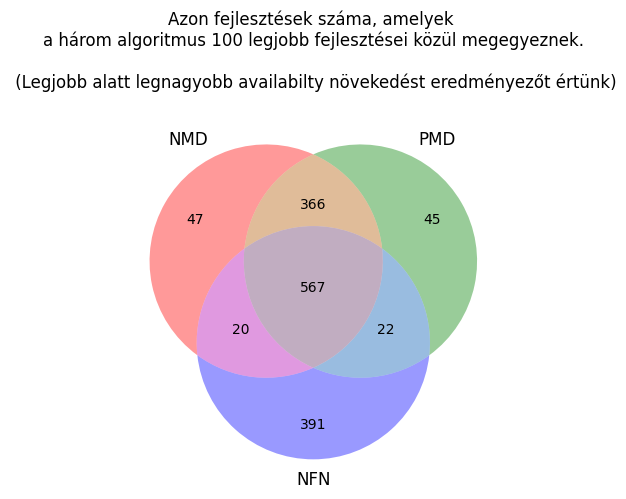

In [69]:
venn3_unweighted(subsets = (
    1000 - all_match - two_match[0] - two_match[1],
    1000 - all_match - two_match[0] - two_match[2],
    two_match[0],
    1000 - all_match - two_match[1] - two_match[2], 
    two_match[1],
    two_match[2], 
    all_match
    ), set_labels = ('NMD', 'PMD', 'NFN'))
plt.title("Azon fejlesztések száma, amelyek \na három algoritmus 100 legjobb fejlesztései közül megegyeznek.\n\n (Legjobb alatt legnagyobb availabilty növekedést eredményezőt értünk)\n")   
plt.show() 

Value alapján rendezzük 

In [70]:
merged_upgrades_with_value.sort(key=get_value, reverse=True)
print(str(len(merged_upgrades_with_value)) + " upgrades in merged")

1458 upgrades in merged


Ki kell még egészíteni azokkal a fejlesztésekkel, amik az előzményei a listában szereplő fejlesztéseknek.\
Tudjuk, hogy minden hálózati elem 6 -os tolerancia szinten van a fejlesztések legelején\
és a maximális tolerancia szint 9\
Tehát megvizsgáljuk mindazon fejlesztéseket, amiknek a tolerance_before mezőjének értéke 7 vagy 8\
\
Elsőnek definiálok pár függvényt\
Az is_upgrade_in_merged megnézi, hogy szerepel-e a keresett fejlesztés az összesített listában\
A find_upgrade_in_merged visszadja az indexét a keresett elemnek az összesített listából\
A find_upgrade_in_network_stats megkeresi a kapott fejlesztést az eredeti beolvasott listában, \
ő akkor kerül meghívásra ha nem találjuk egy fejlesztés előzményét az összesített listában

In [71]:
def is_upgrade_in_merged(network_name, element_type, element, element_idx, tolerance_before):
    for upgrade in merged_upgrades_with_value:
        if(
            upgrade[0] == network_name and
            upgrade[1] == element_type and
            upgrade[2] == element and
            upgrade[3] == element_idx and
            upgrade[5] == tolerance_before
        ):
            return True
    return False

def find_upgrade_in_merged(network_name, element_type, element, element_idx, tolerance_before, tolerance_after):
    for idx in range(len(merged_upgrades_with_value)):
        if(
            merged_upgrades_with_value[idx][0] == network_name and
            merged_upgrades_with_value[idx][1] == element_type and
            merged_upgrades_with_value[idx][2] == element and
            merged_upgrades_with_value[idx][3] == element_idx and
            merged_upgrades_with_value[idx][5] == tolerance_before and
            merged_upgrades_with_value[idx][6] == tolerance_after

        ):
            return idx
        
def find_upgrade_in_network_stats(network_name, element_type, element, element_idx, tolerance_before, tolerance_after):

    sum_cost = 0
    sum_availability = 0
    max_availability = 0

    contains_counter = 0

    for method in scoring_methods:
        for idx in range(len(network_stats_all[method]['upgraded_element_history'])):
            if(
                network_stats_all[method]['upgraded_element_history'][idx][0] == network_name and
                network_stats_all[method]['upgraded_element_history'][idx][1] == element_type and
                network_stats_all[method]['upgraded_element_history'][idx][2] == element and
                network_stats_all[method]['upgraded_element_history'][idx][3] == element_idx and
                network_stats_all[method]['upgraded_element_history'][idx][6] == tolerance_before and
                network_stats_all[method]['upgraded_element_history'][idx][7] == tolerance_after           
                ):
                contains_counter += 1
                sum_cost += network_stats_all[method]['upgraded_element_history'][idx][4]
                sum_availability += network_stats_all[method]['available_area_diff_sum'][idx]
                if(network_stats_all[method]['available_area_diff_sum'][idx] > max_availability): max_availability = network_stats_all[method]['available_area_diff_sum'][idx]

    avg_cost = sum_cost / contains_counter
    avg_availability = sum_availability / contains_counter

    new_upgrade = UpgradeWithValue(
        network_name=network_name,
        element_type=element_type,
        element=element,
        element_idx=element_idx,
        cost=avg_cost,
        tolerance_before=tolerance_before,
        tolerance_after=tolerance_after,
        average_availability_gain=avg_availability,
        biggest_availability_gain=max_availability,
        value=0
    ) 
    
    return new_upgrade

Ebben a részben pedig egybeolvasztjuk azokat a fejlesztéseket, amelyek 7 es vagy 8 as kezdeti toleranciával rendelkeznek\
Egyben fogjuk majd kezelni ezeket a fejlesztéseket (pl: 6 -> 7 és 7-> 8 helyett 6 -> 8)\

Amely fejlesztések az összesített listában 7 es vagy 8 as kezdeti toleranciával rendelkeznek,\ 
azokat el kell távolítani a listából az előzetes fejlesztéseivel együtt már ha benne van\

Ezután össze kell olvasztani az előzményeivel\
ezek az előzmények lehet hogy nem lesznek benn az összesített listában, erre lesz az find_upgrade_in_network_stats függvény, \
amely az eredeti listákban keresi meg az adott fejlesztést

A fejlesztés költsége, az egyes fejlesztések költségének összege lesz\
A value a legnagyobb a fejlesztések value -i közül\
Az átlagos és a legnagyobb availability növekedéseket külön-külön összegezzük

In [72]:
upgrades_to_remove = []
upgrades_to_add = []

tolerance_before_is_7 = 0
tolerance_before_is_8 = 0

remove_counter = 0
add_counter = 0

for upgrade in merged_upgrades_with_value:
    if(
        upgrade[5] == 8
    ):
        upgrade_tolerance_6 = None
        upgrade_tolerance_7 = None
        upgrade_tolerance_8 = upgrade

        biggest_value = upgrade[9]
        cost_sum = upgrade[4]
        availability_sum_avg = upgrade[7]
        availability_sum_max = upgrade[8]


        if(is_upgrade_in_merged(upgrade[0], upgrade[1], upgrade[2], upgrade[3],6)):
            upgrade_tolerance_6_idx = find_upgrade_in_merged(upgrade[0], upgrade[1], upgrade[2], upgrade[3], 6, 7)
            upgrade_tolerance_6 = merged_upgrades_with_value[upgrade_tolerance_6_idx]
            upgrades_to_remove.append(upgrade_tolerance_6)

            availability_sum_avg += upgrade_tolerance_6[7]
            availability_sum_max += upgrade_tolerance_6[8]
            cost_sum += upgrade_tolerance_6[4]

            if(upgrade_tolerance_6[9] > biggest_value): biggest_value = upgrade_tolerance_6[9]    
            remove_counter += 1        
        else:
            temp_upgrade = find_upgrade_in_network_stats(upgrade[0], upgrade[1], upgrade[2], upgrade[3], 6, 7)
            availability_sum_avg += temp_upgrade[7]
            availability_sum_max += temp_upgrade[8]
            cost_sum += temp_upgrade[4]
        
        if(is_upgrade_in_merged(upgrade[0], upgrade[1], upgrade[2], upgrade[3],7)):
            upgrade_tolerance_7_idx = find_upgrade_in_merged(upgrade[0], upgrade[1], upgrade[2], upgrade[3], 7, 8)
            upgrade_tolerance_7 = merged_upgrades_with_value[upgrade_tolerance_7_idx]
            upgrades_to_remove.append(upgrade_tolerance_7)

            availability_sum_avg += upgrade_tolerance_7[7]
            availability_sum_max += upgrade_tolerance_7[8]
            cost_sum += upgrade_tolerance_7[4]

            if(upgrade_tolerance_7[9] > biggest_value): biggest_value = upgrade_tolerance_7[9]   
            remove_counter += 1
        else:
            temp_upgrade = find_upgrade_in_network_stats(upgrade[0], upgrade[1], upgrade[2], upgrade[3], 7, 8)
            availability_sum_avg += temp_upgrade[7]
            availability_sum_max += temp_upgrade[8]
            cost_sum += temp_upgrade[4]
                         
        upgrades_to_remove.append(upgrade_tolerance_8)
        remove_counter += 1
        
        upgrades_to_add.append(UpgradeWithValue(
            network_name=upgrade[0],
            element_type=upgrade[1],
            element=upgrade[2],
            element_idx=upgrade[3],
            cost=cost_sum,
            tolerance_before=6,
            tolerance_after=9,
            average_availability_gain=availability_sum_avg,
            biggest_availability_gain=availability_sum_max,
            value=biggest_value
        ))

        add_counter += 1
        
        tolerance_before_is_8 += 1

for upgrade in merged_upgrades_with_value:
    if(
        upgrade[5] == 7
    ):
        upgrade_tolerance_6 = None
        upgrade_tolerance_7 = upgrade
        tolerance_before_is_7 += 1

        biggest_value = upgrade[9]
        cost_sum = upgrade[4]
        availability_sum_avg = upgrade[7]
        availability_sum_max = upgrade[8]
                
        if(is_upgrade_in_merged(upgrade[0], upgrade[1], upgrade[2], upgrade[3],6)):
            upgrade_tolerance_6_idx = find_upgrade_in_merged(upgrade[0], upgrade[1], upgrade[2], upgrade[3], 6, 7)
            upgrade_tolerance_6 = merged_upgrades_with_value[upgrade_tolerance_6_idx]
            upgrades_to_remove.append(upgrade_tolerance_6)

            availability_sum_avg += upgrade_tolerance_6[7]
            availability_sum_max += upgrade_tolerance_6[8]
            cost_sum += upgrade_tolerance_6[4]

            if(upgrade_tolerance_6[9] > biggest_value): biggest_value = upgrade_tolerance_6[9]
            remove_counter += 1
        else:
            temp_upgrade = find_upgrade_in_network_stats(upgrade[0], upgrade[1], upgrade[2], upgrade[3], 6, 7)
            availability_sum_avg += temp_upgrade[7]
            availability_sum_max += temp_upgrade[8]
            cost_sum += temp_upgrade[4]
        
        upgrades_to_remove.append(upgrade_tolerance_7)
        remove_counter += 1

        upgrades_to_add.append(UpgradeWithValue(
            network_name=upgrade[0],
            element_type=upgrade[1],
            element=upgrade[2],
            element_idx=upgrade[3],
            cost=cost_sum,
            tolerance_before=6,
            tolerance_after=8,
            average_availability_gain=availability_sum_avg,
            biggest_availability_gain=availability_sum_max,
            value=biggest_value
        ))
        add_counter += 1
        

print("There were " + str(tolerance_before_is_7) + " upgrades with the initial tolerance of 7.")
print("There were " + str(tolerance_before_is_8) + " upgrades with the initial tolerance of 8.")

merged_upgrades_with_value = list(set(merged_upgrades_with_value) - set(upgrades_to_remove))
for upgrade in upgrades_to_add:
    merged_upgrades_with_value.append(upgrade)

print(str(remove_counter) + " upgrades were removed.")
print(str(add_counter) + " upgrades were added")

print(str(len(merged_upgrades_with_value)) + " upgrades are in the merged list.")

There were 548 upgrades with the initial tolerance of 7.
There were 386 upgrades with the initial tolerance of 8.
2099 upgrades were removed.
934 upgrades were added
982 upgrades are in the merged list.


Ellenőrzésképpen megnézzük, maradt e olyan fejlesztés a listában, amelynek nem 6 os a kezdeti toleranciája

In [73]:
tolerance_8_counter = 0
tolerance_7_counter = 0

for upgrade in merged_upgrades_with_value:
    if(
        upgrade[5] == 8
    ):
        print(upgrade)
        tolerance_8_counter += 1

for upgrade in merged_upgrades_with_value:
    if(
        upgrade[5] == 7
    ):
        print(upgrade)
        tolerance_7_counter += 1
        

print("The remaining number of upgrades with 7 initial tolerance: " + str(tolerance_7_counter))
print("The remaining number of upgrades with 8 initial tolerance: " + str(tolerance_8_counter))

The remaining number of upgrades with 7 initial tolerance: 0
The remaining number of upgrades with 8 initial tolerance: 0


In [74]:
# Rendezni kell, először value, majd availability alapján
merged_upgrades_with_value.sort(key=lambda x: (x[9], x[7]), reverse=True)

# Másik lista rendezve csak availability alapján
merged_upgrades_sorted = merged_upgrades_with_value
merged_upgrades_sorted.sort(key=get_availability, reverse=True)

In [75]:
with open(f'../data/upgrade/merged_upgrades_with_value.pkl', 'wb') as f:
    pickle.dump(merged_upgrades_sorted, f)

with open(f'../data/upgrade/merged_upgrades_with_value2.pkl', 'wb') as f:
    pickle.dump(merged_upgrades_with_value, f)

Fejlesztési lista mentése, amit majd be lehet olvasni fejlesztésnek

In [76]:
from src.models.id_network import NetworkElementUpgrade

merged_upgrades_sorted_to_save = [NetworkElementUpgrade(
        network_name=upgrade.network_name,
        element_type=upgrade.element_type,
        element=upgrade.element,
        element_idx=upgrade.element_idx,
        score=upgrade.average_availability_gain,
        cost=upgrade.cost,
        tolerance_before=upgrade.tolerance_before,
        tolerance_after=upgrade.tolerance_after
    ) for upgrade in merged_upgrades_sorted]

merged_upgrades_with_value_to_save = [NetworkElementUpgrade(
        network_name=upgrade.network_name,
        element_type=upgrade.element_type,
        element=upgrade.element,
        element_idx=upgrade.element_idx,
        score=upgrade.average_availability_gain,
        cost=upgrade.cost,
        tolerance_before=upgrade.tolerance_before,
        tolerance_after=upgrade.tolerance_after
    ) for upgrade in merged_upgrades_with_value]

In [77]:
with open(f'../data/upgrade/merged_upgrades_with_value_to_save.pkl', 'wb') as f:
    pickle.dump(merged_upgrades_sorted_to_save, f)

with open(f'../data/upgrade/merged_upgrades_with_value_to_save2.pkl', 'wb') as f:
    pickle.dump(merged_upgrades_with_value_to_save, f)